# Session 4: Advanced Univariate Volatility Models

## Course: Advanced Volatility Modeling

---

## Learning Objectives

By the end of this session, students will be able to:
1. Understand long memory in volatility and the FIGARCH model
2. Work with power transformations using APARCH
3. Decompose volatility into permanent and transitory components
4. Apply model selection criteria across complex specifications

---

## 1. Long Memory in Volatility

### 1.1 Motivation

Recall from Session 1: the autocorrelation of squared/absolute returns decays **slowly** - much slower than exponential decay would predict. Standard GARCH models imply **exponential** ACF decay:

$$\rho_k(\epsilon^2) \approx (\alpha + \beta)^k$$

But empirically, we observe **hyperbolic** decay:

$$\rho_k(\epsilon^2) \sim k^{2d-1} \quad \text{as } k \to \infty$$

This is **long memory** (or long-range dependence) with parameter $d \in (0, 0.5)$.

### 1.2 Fractional Integration

A time series $y_t$ is **integrated of order $d$**, denoted $I(d)$, if:

$$(1 - L)^d y_t = u_t$$

where $u_t$ is stationary and $L$ is the lag operator.

The **fractional difference operator** is defined via binomial expansion:

$$(1-L)^d = \sum_{j=0}^{\infty} \binom{d}{j} (-L)^j = 1 - dL - \frac{d(1-d)}{2}L^2 - \cdots$$

For $d \in (0, 0.5)$: stationary with long memory
For $d = 0$: standard stationary process
For $d = 1$: unit root (random walk)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_func
from scipy.optimize import minimize
import yfinance as yf
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

np.random.seed(42)

In [4]:
# Download data
spy = yf.download('SPY', start='2000-01-01', end='2024-12-31', progress=False)
if isinstance(spy.columns, pd.MultiIndex):
    spy.columns = spy.columns.get_level_values(0)

returns = (np.log(spy['Close'] / spy['Close'].shift(1)) * 100).dropna()
abs_returns = np.abs(returns)

print(f"Sample: {returns.index[0].date()} to {returns.index[-1].date()}")
print(f"Observations: {len(returns)}")

YF.download() has changed argument auto_adjust default to True
Sample: 2000-01-04 to 2024-12-30
Observations: 6287


In [5]:
def estimate_d_gph(series, m=None):
    """
    Estimate fractional differencing parameter d using GPH estimator.
    
    The GPH (Geweke-Porter-Hudak) estimator uses the periodogram.
    
    Parameters
    ----------
    series : array-like
        Time series
    m : int
        Number of low-frequency ordinates to use (default: T^0.5)
    
    Returns
    -------
    d_hat : float
        Estimated d
    se : float
        Standard error
    """
    T = len(series)
    if m is None:
        m = int(T ** 0.5)
    
    # Compute periodogram
    fft_vals = np.fft.fft(series - series.mean())
    periodogram = np.abs(fft_vals) ** 2 / T
    
    # Frequencies
    freqs = 2 * np.pi * np.arange(1, m + 1) / T
    
    # Log-periodogram regression
    y = np.log(periodogram[1:m+1])
    x = np.log(4 * np.sin(freqs / 2) ** 2)
    
    # OLS
    x_dm = x - x.mean()
    d_hat = -np.sum(x_dm * y) / np.sum(x_dm ** 2) / 2
    
    # Standard error
    se = np.pi / (np.sqrt(24) * np.sqrt(np.sum(x_dm ** 2)))
    
    return d_hat, se

# Estimate d for absolute returns
d_hat, se = estimate_d_gph(abs_returns.values)

print("GPH Estimation of Long Memory Parameter")
print("="*50)
print(f"d̂ = {d_hat:.4f}")
print(f"Standard Error = {se:.4f}")
print(f"95% CI: [{d_hat - 1.96*se:.4f}, {d_hat + 1.96*se:.4f}]")
print(f"\nInterpretation:")
if 0 < d_hat < 0.5:
    print(f"d ∈ (0, 0.5): Stationary long memory")
    print(f"ACF decays like k^{2*d_hat - 1:.2f} (hyperbolic)")

GPH Estimation of Long Memory Parameter
d̂ = 0.2140
Standard Error = 0.0396
95% CI: [0.1364, 0.2917]

Interpretation:
d ∈ (0, 0.5): Stationary long memory
ACF decays like k^-0.57 (hyperbolic)


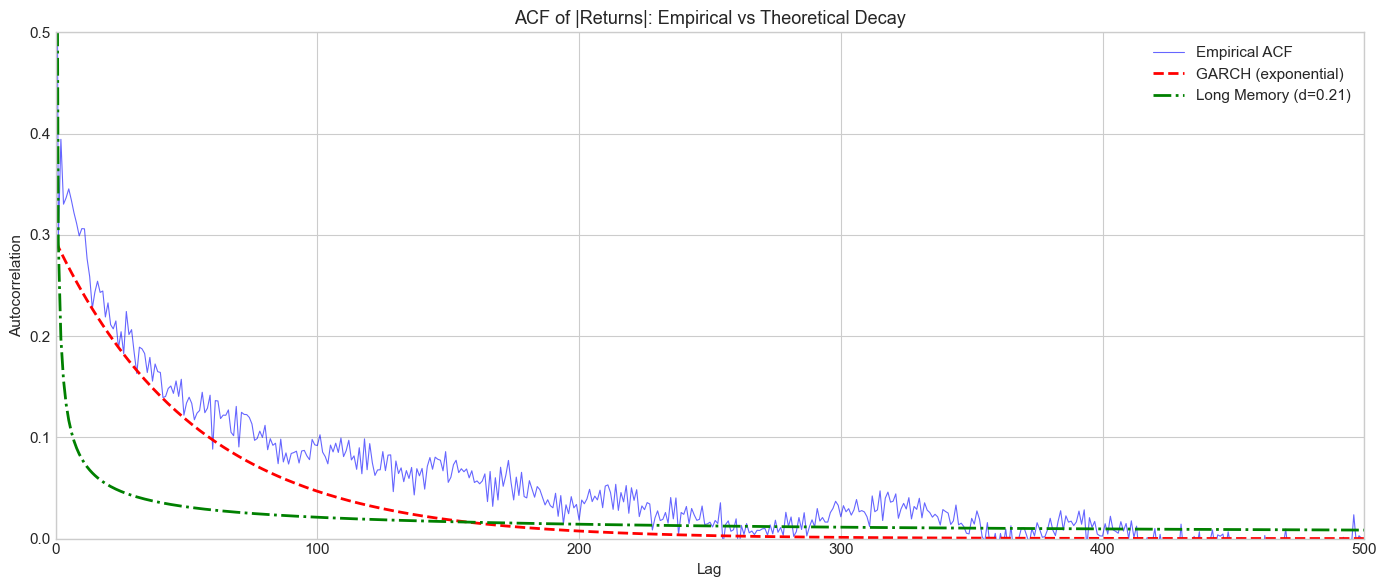


The empirical ACF decays much slower than GARCH predicts,
consistent with long memory in volatility.


In [6]:
# Compare empirical ACF decay to theoretical
def compute_acf(series, max_lag):
    """Compute sample ACF."""
    n = len(series)
    mean = series.mean()
    var = series.var()
    acf = np.zeros(max_lag + 1)
    acf[0] = 1.0
    
    for k in range(1, max_lag + 1):
        acf[k] = np.mean((series.iloc[k:] - mean).values * (series.iloc[:-k] - mean).values) / var
    
    return acf

max_lag = 500
acf_empirical = compute_acf(abs_returns, max_lag)

# Theoretical ACF under GARCH (exponential decay)
garch_fit = arch_model(returns, vol='Garch', p=1, q=1).fit(disp='off')
persistence = garch_fit.params['alpha[1]'] + garch_fit.params['beta[1]']
acf_garch = persistence ** np.arange(max_lag + 1) * acf_empirical[1]

# Theoretical ACF under long memory (hyperbolic decay)
lags = np.arange(1, max_lag + 1)
acf_long_memory = acf_empirical[1] * lags ** (2 * d_hat - 1)
acf_long_memory = np.concatenate([[1], acf_long_memory])

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(acf_empirical, 'b-', alpha=0.6, linewidth=0.8, label='Empirical ACF')
ax.plot(acf_garch, 'r--', linewidth=2, label='GARCH (exponential)')
ax.plot(acf_long_memory, 'g-.', linewidth=2, label=f'Long Memory (d={d_hat:.2f})')

ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('ACF of |Returns|: Empirical vs Theoretical Decay', fontsize=13)
ax.legend(loc='upper right')
ax.set_xlim(0, max_lag)
ax.set_ylim(0, 0.5)

plt.tight_layout()
plt.show()

print("\nThe empirical ACF decays much slower than GARCH predicts,")
print("consistent with long memory in volatility.")

## 2. FIGARCH Model

### 2.1 Model Specification

Baillie, Bollerslev & Mikkelsen (1996) introduced **Fractionally Integrated GARCH**:

$$\boxed{\phi(L)(1-L)^d \epsilon_t^2 = \omega + [1 - \beta(L)]v_t}$$

where $v_t = \epsilon_t^2 - \sigma_t^2$.

For FIGARCH(1,d,1):

$$\sigma_t^2 = \omega + \beta \sigma_{t-1}^2 + [1 - \beta L - (1-\phi L)(1-L)^d]\epsilon_t^2$$

### 2.2 Special Cases

- $d = 0$: Standard GARCH (short memory)
- $d = 1$: IGARCH (unit root)
- $d \in (0, 1)$: Long memory

### 2.3 Properties

- ACF of $\epsilon_t^2$ decays hyperbolically: $\rho_k \sim k^{2d-1}$
- Impulse response also decays hyperbolically
- Forecasts revert to long-run mean but slowly

In [18]:
# Fit FIGARCH using arch library
model_figarch = arch_model(returns, vol='FIGARCH', p=1, q=1, power=2.0)
fit_figarch = model_figarch.fit(disp='off')

print("FIGARCH(1,d,1) Estimation Results")
print("="*60)
print(fit_figarch.summary())

d_figarch = fit_figarch.params['d']
print(f"\nEstimated d = {d_figarch:.4f}")
print(f"This is {'similar to' if abs(d_figarch - d_hat) < 0.1 else 'different from'} the GPH estimate ({d_hat:.4f})")

FIGARCH(1,d,1) Estimation Results
                    Constant Mean - FIGARCH Model Results                     
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                    FIGARCH   Log-Likelihood:               -8627.81
Distribution:                  Normal   AIC:                           17265.6
Method:            Maximum Likelihood   BIC:                           17299.3
                                        No. Observations:                 6287
Date:                Thu, Feb 05 2026   Df Residuals:                     6286
Time:                        09:36:22   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0731  1

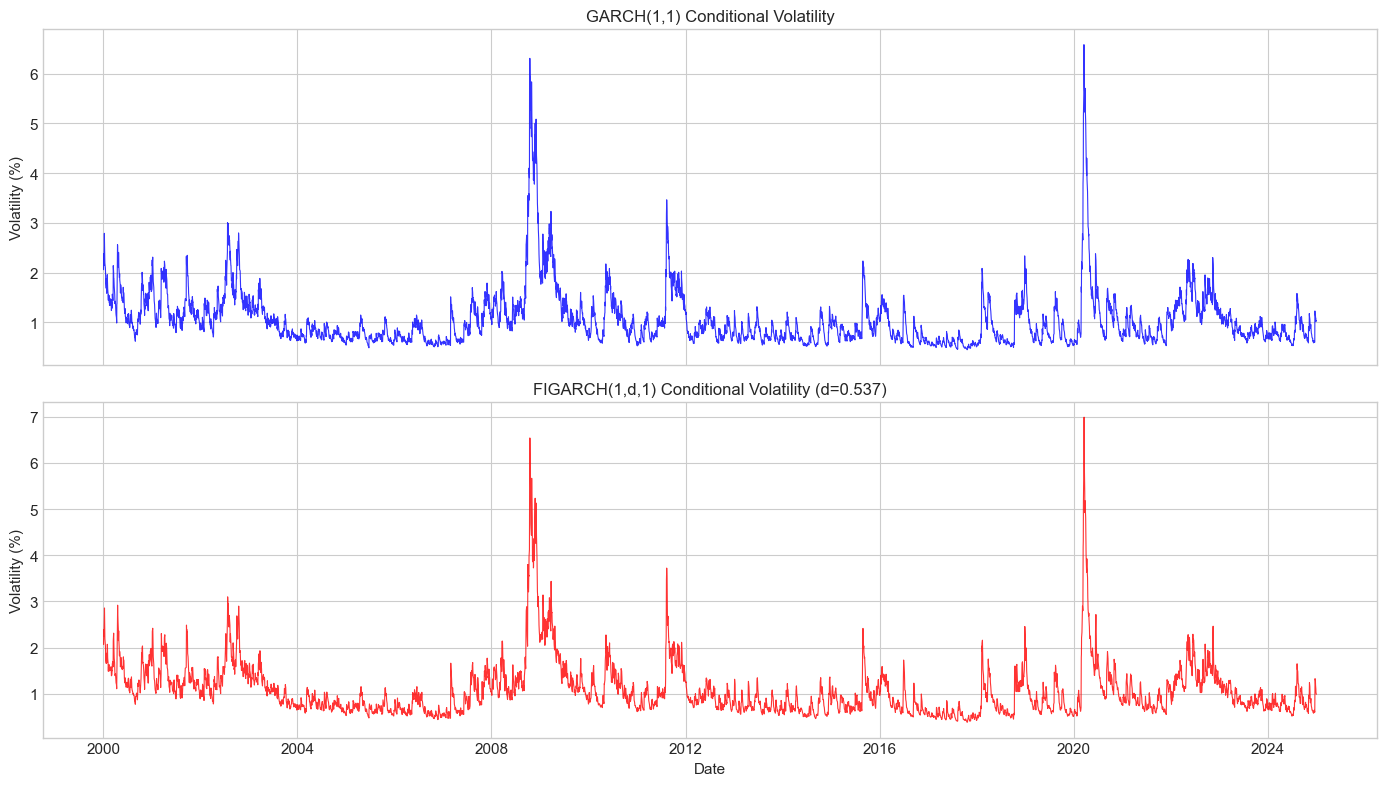


Model Comparison:
Model                     Log-Lik          AIC          BIC
------------------------------------------------------------
GARCH(1,1)               -8644.06     17296.12     17323.10
FIGARCH(1,d,1)           -8627.81     17265.61     17299.34


In [9]:
# Compare GARCH vs FIGARCH volatility
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

vol_garch = garch_fit.conditional_volatility
vol_figarch = fit_figarch.conditional_volatility

axes[0].plot(vol_garch.index, vol_garch.values, 'b-', linewidth=0.8, alpha=0.8)
axes[0].set_title('GARCH(1,1) Conditional Volatility', fontsize=12)
axes[0].set_ylabel('Volatility (%)')

axes[1].plot(vol_figarch.index, vol_figarch.values, 'r-', linewidth=0.8, alpha=0.8)
axes[1].set_title(f'FIGARCH(1,d,1) Conditional Volatility (d={d_figarch:.3f})', fontsize=12)
axes[1].set_ylabel('Volatility (%)')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

# Model comparison
print(f"\nModel Comparison:")
print(f"{'Model':<20} {'Log-Lik':>12} {'AIC':>12} {'BIC':>12}")
print("-"*60)
print(f"{'GARCH(1,1)':<20} {garch_fit.loglikelihood:>12.2f} {garch_fit.aic:>12.2f} {garch_fit.bic:>12.2f}")
print(f"{'FIGARCH(1,d,1)':<20} {fit_figarch.loglikelihood:>12.2f} {fit_figarch.aic:>12.2f} {fit_figarch.bic:>12.2f}")

## 3. APARCH Model

### 3.1 Model Specification

Ding, Granger & Engle (1993) proposed the **Asymmetric Power ARCH** model:

$$\boxed{\sigma_t^\delta = \omega + \sum_{i=1}^{q} \alpha_i (|\epsilon_{t-i}| - \gamma_i \epsilon_{t-i})^\delta + \sum_{j=1}^{p} \beta_j \sigma_{t-j}^\delta}$$

Key features:
- **Power parameter $\delta$**: transforms volatility (data-driven, not fixed at 2)
- **Asymmetry $\gamma_i$**: leverage effect (similar to GJR-GARCH)

### 3.2 Special Cases

| $\delta$ | $\gamma$ | Model |
|----------|----------|-------|
| 2 | 0 | GARCH |
| 2 | $\neq 0$ | GJR-GARCH |
| 1 | 0 | AVGARCH (Taylor) |
| 1 | $\neq 0$ | TGARCH (Zakoian) |

### 3.3 Optimal Power

Ding et al. (1993) showed that $|r_t|^\delta$ has maximum autocorrelation around $\delta \approx 1$ for equity returns, not $\delta = 2$!

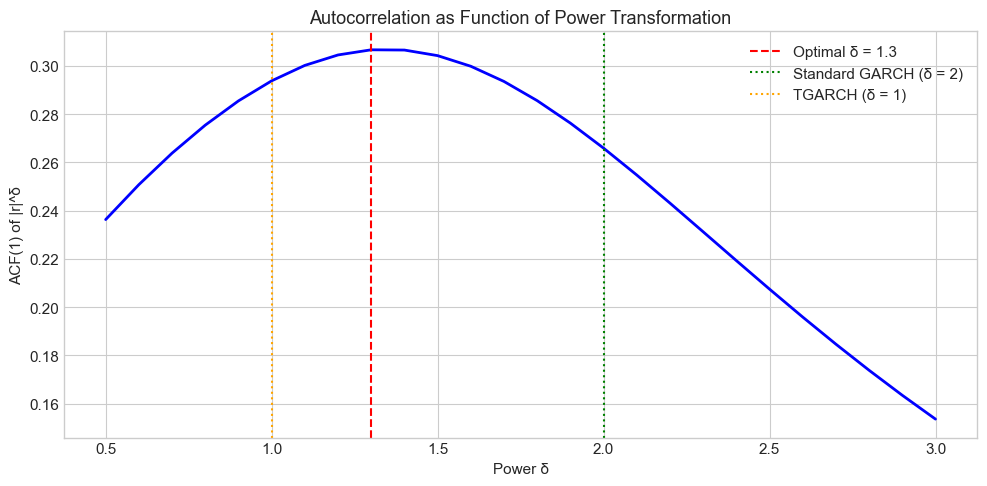

Optimal power: δ = 1.30
ACF(1) at optimal power: 0.3066
ACF(1) at δ=2 (GARCH): 0.2659


In [92]:
# Find optimal power transformation
def find_optimal_power(returns, powers=np.arange(0.5, 3.1, 0.1)):
    """
    Find power δ that maximizes ACF(1) of |r|^δ.
    """
    acf1_values = []
    
    for delta in powers:
        transformed = np.abs(returns) ** delta
        acf1 = transformed.autocorr(lag=1)
        acf1_values.append(acf1)
    
    return powers, np.array(acf1_values)

powers, acf1s = find_optimal_power(returns)
optimal_power = powers[np.argmax(acf1s)]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(powers, acf1s, 'b-', linewidth=2)
ax.axvline(optimal_power, color='red', linestyle='--', label=f'Optimal δ = {optimal_power:.1f}')
ax.axvline(2.0, color='green', linestyle=':', label='Standard GARCH (δ = 2)')
ax.axvline(1.0, color='orange', linestyle=':', label='TGARCH (δ = 1)')

ax.set_xlabel('Power δ')
ax.set_ylabel('ACF(1) of |r|^δ')
ax.set_title('Autocorrelation as Function of Power Transformation', fontsize=13)
ax.legend()

plt.tight_layout()
plt.show()

print(f"Optimal power: δ = {optimal_power:.2f}")
print(f"ACF(1) at optimal power: {acf1s[np.argmax(acf1s)]:.4f}")
powers = [round(x,2) for x in powers]
print(f"ACF(1) at δ=2 (GARCH): {acf1s[[x==2. for x in powers]][0]:.4f}")

In [94]:
# Fit APARCH with estimated power
model_aparch = arch_model(returns, vol='APARCH', p=1, o=1, q=1, dist='t')
fit_aparch = model_aparch.fit(disp='off')

print("APARCH(1,1) Estimation Results")
print("="*60)
print(fit_aparch.summary().tables[1])

delta_hat = fit_aparch.params['delta']
gamma_hat = fit_aparch.params['gamma[1]']

print(f"\nEstimated δ = {delta_hat:.4f}")
print(f"Estimated γ = {gamma_hat:.4f}")
print(f"\nThe estimated power is {'close to' if abs(delta_hat - optimal_power) < 0.3 else 'different from'} the grid search optimal ({optimal_power:.1f})")

APARCH(1,1) Estimation Results
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0514  8.671e-03      5.929  3.042e-09 [3.442e-02,6.841e-02]

Estimated δ = 0.9397
Estimated γ = 0.9997

The estimated power is different from the grid search optimal (1.3)


## 4. Component GARCH

### 4.1 Motivation

Volatility appears to have multiple components operating at different time scales:
- **Long-run (permanent) component**: slow-moving trend
- **Short-run (transitory) component**: mean-reverting around trend

### 4.2 Model Specification (Engle & Lee, 1999)

$$\sigma_t^2 = q_t + s_t$$

where:

**Long-run component** (slow mean reversion):
$$q_t = \omega + \rho (q_{t-1} - \omega) + \phi(\epsilon_{t-1}^2 - \sigma_{t-1}^2)$$

**Short-run component** (fast mean reversion):
$$s_t = \alpha(\epsilon_{t-1}^2 - q_{t-1}) + \beta s_{t-1}$$

Key: $\rho$ (long-run persistence) > $\alpha + \beta$ (short-run persistence)

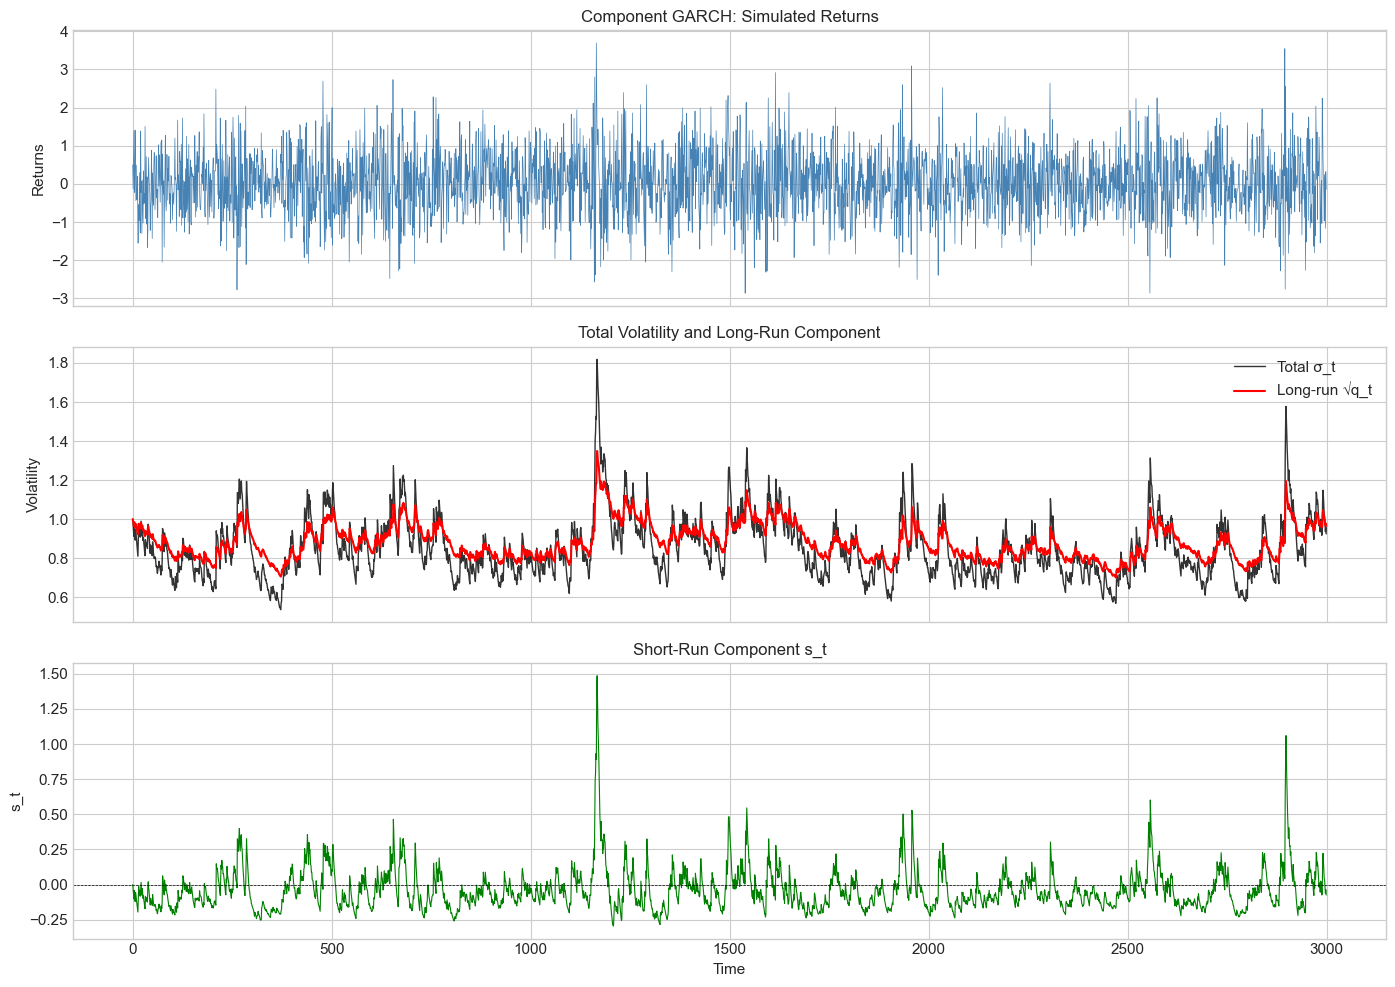

Long-run persistence (ρ): 0.995
Short-run persistence (α+β): 0.950

The long-run component captures slow trends in volatility.


In [97]:
def simulate_component_garch(n, omega, rho, phi, alpha, beta, seed=None):
    """
    Simulate Component GARCH process.
    
    σ²_t = q_t + s_t
    q_t = ω + ρ(q_{t-1} - ω) + φ(ε²_{t-1} - σ²_{t-1})   [long-run]
    s_t = α(ε²_{t-1} - q_{t-1}) + β s_{t-1}              [short-run]
    """
    if seed is not None:
        np.random.seed(seed)
    
    eps = np.zeros(n)
    sigma2 = np.zeros(n)
    q = np.zeros(n)  # Long-run component
    s = np.zeros(n)  # Short-run component
    
    z = np.random.standard_normal(n)
    
    # Initialize at unconditional values
    q[0] = omega
    s[0] = 0
    sigma2[0] = q[0] + s[0]
    eps[0] = np.sqrt(sigma2[0]) * z[0]
    
    for t in range(1, n):
        # Long-run component
        q[t] = omega + rho * (q[t-1] - omega) + phi * (eps[t-1]**2 - sigma2[t-1])
        
        # Short-run component
        s[t] = alpha * (eps[t-1]**2 - q[t-1]) + beta * s[t-1]
        
        # Total variance
        sigma2[t] = max(q[t] + s[t], 1e-8)  # Ensure positive
        
        eps[t] = np.sqrt(sigma2[t]) * z[t]
    
    return eps, sigma2, q, s

# Simulate
n = 3000
omega = 1.0
rho = 0.995    # Very persistent long-run
phi = 0.03
alpha = 0.05
beta = 0.90    # Less persistent short-run

eps_comp, sigma2_comp, q_comp, s_comp = simulate_component_garch(
    n, omega, rho, phi, alpha, beta, seed=42
)

# Plot
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

axes[0].plot(eps_comp, color='steelblue', linewidth=0.5)
axes[0].set_title('Component GARCH: Simulated Returns', fontsize=12)
axes[0].set_ylabel('Returns')

axes[1].plot(np.sqrt(sigma2_comp), 'k-', linewidth=1, label='Total σ_t', alpha=0.8)
axes[1].plot(np.sqrt(q_comp), 'r-', linewidth=1.5, label='Long-run √q_t')
axes[1].set_title('Total Volatility and Long-Run Component', fontsize=12)
axes[1].set_ylabel('Volatility')
axes[1].legend()

axes[2].plot(s_comp, 'g-', linewidth=0.8)
axes[2].axhline(0, color='black', linestyle='--', linewidth=0.5)
axes[2].set_title('Short-Run Component s_t', fontsize=12)
axes[2].set_ylabel('s_t')
axes[2].set_xlabel('Time')

plt.tight_layout()
plt.show()

print(f"Long-run persistence (ρ): {rho:.3f}")
print(f"Short-run persistence (α+β): {alpha + beta:.3f}")
print(f"\nThe long-run component captures slow trends in volatility.")

In [98]:
# Fit Component GARCH to real data
# Note: arch doesn't have built-in CGARCH, so we use HARCH as approximation
# or fit manually

def fit_component_garch_simple(returns, max_iter=1000):
    """
    Fit simplified Component GARCH by MLE.
    """
    returns = np.asarray(returns)
    T = len(returns)
    
    def neg_loglik(params):
        omega, rho, phi, alpha, beta = params
        
        # Constraints
        if omega <= 0 or not (0 < rho < 1) or alpha < 0 or beta < 0:
            return 1e10
        if alpha + beta >= 1:
            return 1e10
        
        sigma2 = np.zeros(T)
        q = np.zeros(T)
        s = np.zeros(T)
        
        q[0] = returns.var()
        s[0] = 0
        sigma2[0] = q[0]
        
        for t in range(1, T):
            q[t] = omega + rho * (q[t-1] - omega) + phi * (returns[t-1]**2 - sigma2[t-1])
            s[t] = alpha * (returns[t-1]**2 - q[t-1]) + beta * s[t-1]
            sigma2[t] = max(q[t] + s[t], 1e-8)
        
        # Log-likelihood
        ll = -0.5 * np.sum(np.log(2*np.pi) + np.log(sigma2) + returns**2/sigma2)
        return -ll
    
    # Initial guess
    var0 = returns.var()
    x0 = [var0 * 0.1, 0.99, 0.01, 0.05, 0.85]
    
    result = minimize(neg_loglik, x0, method='Nelder-Mead', 
                     options={'maxiter': max_iter})
    
    return result

# Fit to S&P 500
cgarch_result = fit_component_garch_simple(returns.values)

print("Component GARCH Estimation Results")
print("="*50)
params = cgarch_result.x
print(f"ω (long-run mean): {params[0]:.4f}")
print(f"ρ (long-run persistence): {params[1]:.4f}")
print(f"φ (long-run news): {params[2]:.4f}")
print(f"α (short-run news): {params[3]:.4f}")
print(f"β (short-run persistence): {params[4]:.4f}")
print(f"\nShort-run persistence (α+β): {params[3] + params[4]:.4f}")
print(f"Log-likelihood: {-cgarch_result.fun:.2f}")

Component GARCH Estimation Results
ω (long-run mean): 0.2235
ρ (long-run persistence): 1.0000
φ (long-run news): -0.0020
α (short-run news): 0.0903
β (short-run persistence): 0.8965

Short-run persistence (α+β): 0.9868
Log-likelihood: -8679.24


## 5. Model Comparison and Selection

In [101]:
# Comprehensive model comparison
models_to_fit = [
    ('GARCH(1,1)', {'vol': 'Garch', 'p': 1, 'q': 1}),
    ('GJR-GARCH(1,1)', {'vol': 'Garch', 'p': 1, 'o': 1, 'q': 1}),
    ('EGARCH(1,1)', {'vol': 'EGARCH', 'p': 1, 'o': 1, 'q': 1}),
    ('FIGARCH(1,d,1)', {'vol': 'FIGARCH', 'p': 1, 'q': 1}),
    ('APARCH(1,1)', {'vol': 'APARCH', 'p': 1, 'o': 1, 'q': 1}),
]

results = []
for name, spec in models_to_fit:
    try:
        model = arch_model(returns, dist='t', **spec)
        fit = model.fit(disp='off')
        results.append({
            'Model': name,
            'Log-Lik': fit.loglikelihood,
            'AIC': fit.aic,
            'BIC': fit.bic,
            'Params': fit.num_params
        })
    except Exception as e:
        print(f"Failed to fit {name}: {e}")

results_df = pd.DataFrame(results).set_index('Model')
results_df = results_df.sort_values('BIC')

print("\nModel Comparison (S&P 500 Daily Returns)")
print("="*70)
print(results_df.round(2))
print(f"\nBest model by BIC: {results_df['BIC'].idxmin()}")


Model Comparison (S&P 500 Daily Returns)
                Log-Lik       AIC       BIC  Params
Model                                              
APARCH(1,1)    -8354.42  16722.84  16770.06       7
EGARCH(1,1)    -8370.72  16753.44  16793.92       6
GJR-GARCH(1,1) -8394.93  16801.86  16842.34       6
FIGARCH(1,d,1) -8476.09  16964.17  17004.65       6
GARCH(1,1)     -8499.09  17008.18  17041.91       5

Best model by BIC: APARCH(1,1)


## 6. Forecasting Comparison

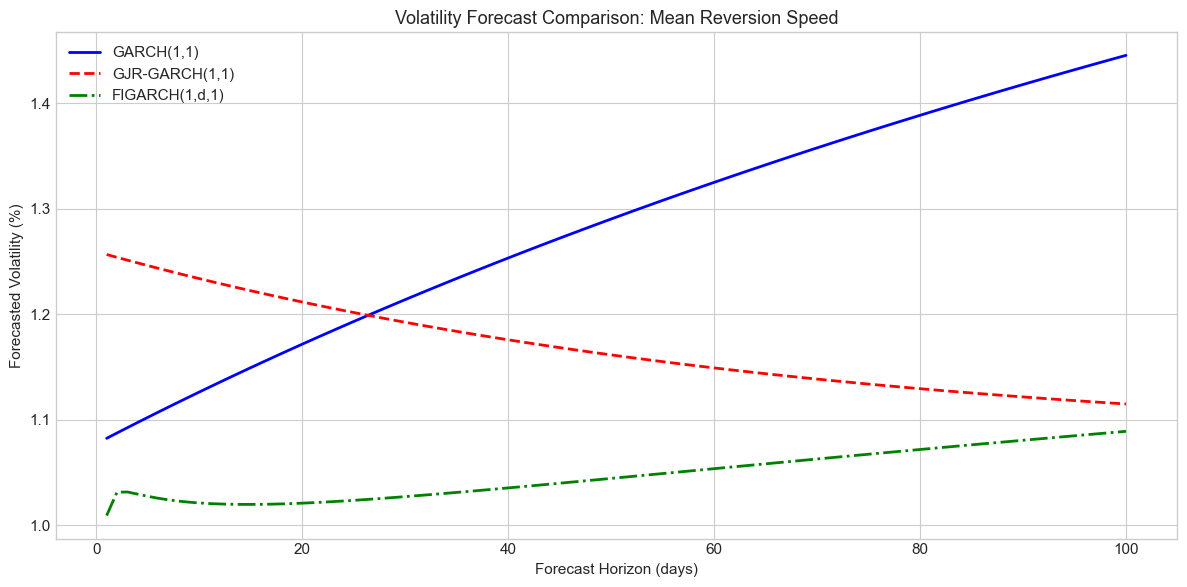


Key observation:
FIGARCH forecasts decay more slowly to the long-run mean,
reflecting the long memory property.


In [103]:
# Compare long-horizon forecasts
horizon = 100

# Fit models
fit_garch = arch_model(returns, vol='Garch', p=1, q=1, dist='t').fit(disp='off')
fit_gjr = arch_model(returns, vol='Garch', p=1, o=1, q=1, dist='t').fit(disp='off')
fit_figarch = arch_model(returns, vol='FIGARCH', p=1, q=1, dist='t').fit(disp='off')

# Generate forecasts
fcast_garch = fit_garch.forecast(horizon=horizon, reindex=False)
fcast_gjr = fit_gjr.forecast(horizon=horizon, reindex=False)
fcast_figarch = fit_figarch.forecast(horizon=horizon, reindex=False)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

days = np.arange(1, horizon + 1)

ax.plot(days, np.sqrt(fcast_garch.variance.iloc[-1].values), 
        'b-', linewidth=2, label='GARCH(1,1)')
ax.plot(days, np.sqrt(fcast_gjr.variance.iloc[-1].values), 
        'r--', linewidth=2, label='GJR-GARCH(1,1)')
ax.plot(days, np.sqrt(fcast_figarch.variance.iloc[-1].values), 
        'g-.', linewidth=2, label='FIGARCH(1,d,1)')

ax.set_xlabel('Forecast Horizon (days)')
ax.set_ylabel('Forecasted Volatility (%)')
ax.set_title('Volatility Forecast Comparison: Mean Reversion Speed', fontsize=13)
ax.legend()

plt.tight_layout()
plt.show()

print("\nKey observation:")
print("FIGARCH forecasts decay more slowly to the long-run mean,")
print("reflecting the long memory property.")

## 7. Summary

### Key Takeaways

1. **Long memory**: Volatility autocorrelations decay hyperbolically ($\sim k^{2d-1}$), not exponentially

2. **FIGARCH**: Captures long memory via fractional differencing; $d \approx 0.3-0.5$ typical for equities

3. **APARCH**: Data-driven power transformation; optimal $\delta \approx 1$ for many assets (not 2!)

4. **Component GARCH**: Separates permanent and transitory volatility components

5. **Model selection**: BIC often favors parsimonious models; complex models need careful evaluation

### Preview of Session 5

Session 5 shifts to **Realized Volatility**: using high-frequency data to measure volatility directly, rather than as a latent variable.

## Exercises

### Exercise 1: Long Memory Estimation
Estimate the fractional differencing parameter $d$ for Bitcoin, Gold, and EUR/USD using both GPH and FIGARCH. How do they compare?

### Exercise 2: Optimal Power
Find the optimal power $\delta$ for maximizing ACF(1) of $|r|^\delta$ for cryptocurrencies. Is it different from equities?

### Exercise 3: FIEGARCH
The arch library supports FIEGARCH (Fractionally Integrated EGARCH). Fit this model to S&P 500 and compare to FIGARCH.

### Exercise 4: Component Decomposition
Fit Component GARCH to Bitcoin. What are the relative contributions of permanent vs transitory components during major crashes?

### Exercise 5: Forecast Evaluation
Compare GARCH, GJR-GARCH, FIGARCH, and APARCH forecasts using rolling 1-step-ahead evaluation over 2020-2024. Which model performs best during high vs low volatility periods?

## References

1. Baillie, R. T., Bollerslev, T., & Mikkelsen, H. O. (1996). Fractionally integrated generalized autoregressive conditional heteroskedasticity. *Journal of Econometrics*, 74(1), 3-30.

2. Ding, Z., Granger, C. W., & Engle, R. F. (1993). A long memory property of stock market returns and a new model. *Journal of Empirical Finance*, 1(1), 83-106.

3. Engle, R. F., & Lee, G. (1999). A long-run and short-run component model of stock return volatility. *Cointegration, Causality, and Forecasting*, 475-497.

4. Andersen, T. G., & Bollerslev, T. (1997). Heterogeneous information arrivals and return volatility dynamics. *Journal of Finance*, 52(3), 975-1005.